# Proyecto 1: Inteligencia Artificial Aplicada a la Ingeniería Eléctrica

## Algoritmo 1: K-means

In [265]:
# Importamos las librerías
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [266]:
# Importamos los datos del anexo A
csv_file = 'AnexoA.csv'
datosA = pd.read_csv(csv_file)
print(datosA.info())
print(datosA.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Empresa   133 non-null    object 
 1   Circuito  133 non-null    object 
 2   Abonados  133 non-null    int64  
 3   DPIR      133 non-null    float64
 4   FPI       133 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 5.3+ KB
None
           Abonados        DPIR         FPI
count    133.000000  133.000000  133.000000
mean    7011.180451   16.092857   13.393985
std     4649.287868    8.908077    6.568216
min        1.000000    6.350000    1.020000
25%     3756.000000    8.930000    8.790000
50%     6181.000000   13.900000   11.790000
75%    10556.000000   20.480000   16.710000
max    21394.000000   54.660000   31.470000


In [267]:
# Importamos los datos del anexo b
csv_file = 'AnexoB.csv'
datosB = pd.read_csv(csv_file)
print(datosB.info())
print(datosB.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Empresa   352 non-null    object 
 1   Circuito  352 non-null    object 
 2   Abonados  352 non-null    int64  
 3   DPIR      352 non-null    float64
 4   FPI       352 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 13.9+ KB
None
           Abonados        DPIR         FPI
count    352.000000  352.000000  352.000000
mean    4357.656250    2.598580    2.494119
std     6918.736094    1.930275    1.981300
min        0.000000    0.000000    0.000000
25%      244.250000    0.662500    0.872500
50%     1835.000000    2.675000    2.350000
75%     5977.750000    4.250000    4.000000
max    58034.000000    5.970000    6.990000


In [268]:
# Análisis exploratorio gráfica de los datos


fig = px.scatter_3d(datosA, x="Abonados", y="DPIR", z="FPI", title="Datos Anexo A")
fig.update_traces(
    textfont=dict(
        family="Arial",
        size=18,
        color='red' 
    ),
    marker=dict(
        size=5
    )
)
fig.show()                        

In [269]:
# Análisis exploratorio gráfica de los datos
fig = px.scatter_3d(datosB, x="Abonados", y="DPIR", z="FPI", title="Datos Anexo B")
fig.update_traces(
    textfont=dict(
        family="Arial",
        size=18,
        color="crimson"  
    ),
    marker=dict(
        size=5
    )
)
fig.show()

***Escalamos los datos***

In [270]:
data = datosA.select_dtypes(include=[int,float])
scaler = StandardScaler() #investigar qué hace
data = scaler.fit_transform(data)

### Método del codo

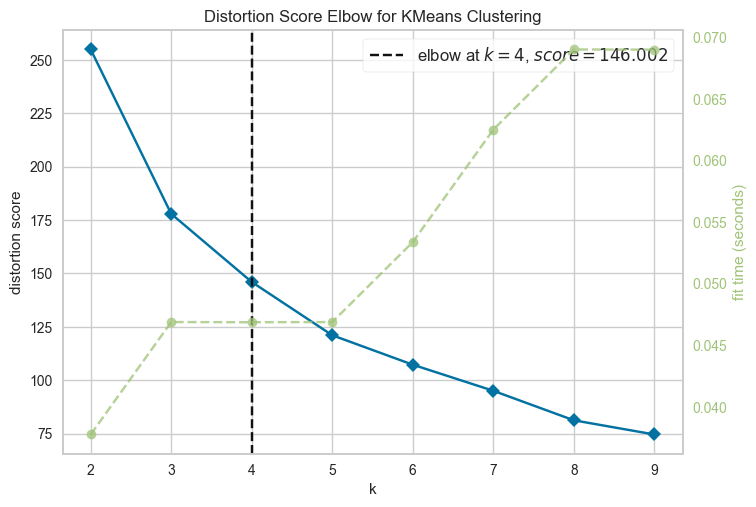

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [271]:
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,10))
 
visualizer.fit(data)        # Fit the data to the visualizer
visualizer.show()

Visualizamos que el gráfico no converge, sino que sigue bajando indefinidamente. Se elige k = 4 porque la librería yellowbrick proporciona un gráfico que sugiere un valor de k adecuado.

In [272]:
# Elegimos k = 4 a partir de la gráfica
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit(data)
y_means = kmeans.predict(data).astype(str)
y_means = y_means.reshape(133,1)
centers = scaler.inverse_transform(kmeans.cluster_centers_) #quitamos escalamientos

data_kmeans_elbow =  datosA.copy()
data_kmeans_elbow["Cluster"]= y_means

In [273]:
fig = px.scatter_3d(data_kmeans_elbow, x="Abonados", y="DPIR", z="FPI", color="Cluster", 
                    title='Clústers hechos con K-means y método del codo')
fig.add_trace(go.Scatter3d(
    x=centers[:, 0],
    y=centers[:, 1],
    z=centers[:, 2],
    mode='markers',
    marker=dict(size=20, color='yellow',symbol='diamond'),
    name='Centroids'
))

fig.update_traces(
    textfont=dict(
        family="Arial",
        size=15,
        color="crimson"  
    ),
    marker=dict(
        size=5,
    )
)
fig.show()

#### Estadísticas

In [274]:
data_kmeans_grouped = data_kmeans_elbow.groupby("Cluster").agg({"Abonados":['mean'],
                                    "DPIR":['mean'],
                                    "FPI":['mean'],
                                  "Empresa":[pd.Series.mode],
                                    "Cluster":'count'})
print(data_kmeans_grouped)

          Abonados       DPIR        FPI Empresa Cluster
              mean       mean       mean    mode   count
Cluster                                                 
0        12661.425  10.989500  11.214750    CNFL      40
1         5175.600  27.037000  15.366333     ICE      30
2         4856.000  21.261333  27.410667     ICE      15
3         4123.375  11.890417   9.597083     ICE      48


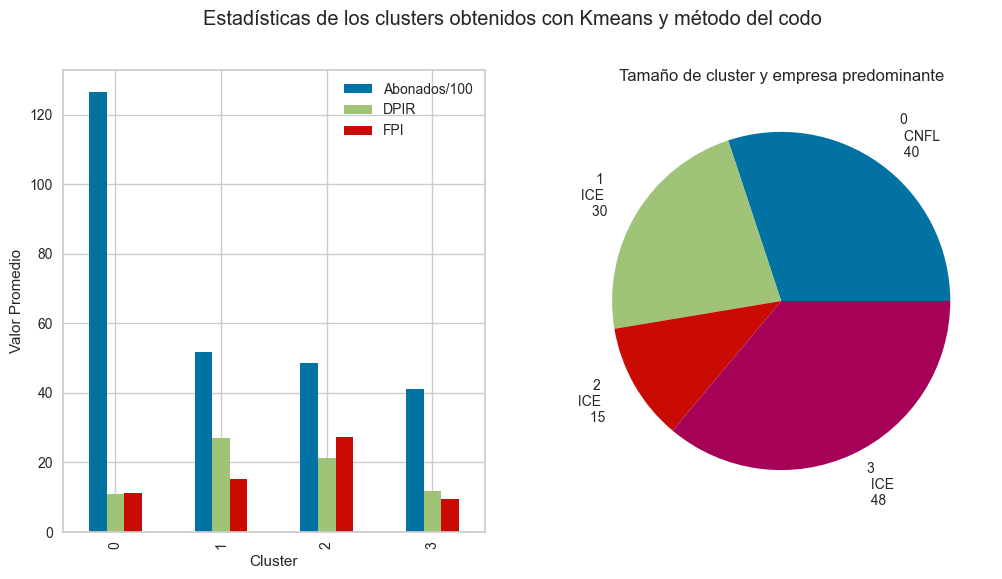

In [275]:
# generamos gráficos más comprensibles
data_kmeans_grouped1 = data_kmeans_elbow.groupby("Cluster").agg({"Abonados":['mean'],
                                    "DPIR":['mean'],
                                    "FPI":['mean'],
                                  "Empresa":[pd.Series.mode]
                                    })

data_kmeans_grouped1['Abonados'] = data_kmeans_grouped1['Abonados']/100
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
data_kmeans_grouped1.plot(kind='bar',ax=ax[0], xlabel='Cluster', ylabel='Valor Promedio')
ax[0].legend(['Abonados/100', 'DPIR', 'FPI'])

empresas=[data_kmeans_grouped1.Empresa.values[i][0] for i in range(len(data_kmeans_grouped1.Empresa.values))]
data_kmeans_grouped2 = data_kmeans_elbow.groupby("Cluster").agg({"Cluster":'count'})


formatter = [f"{i} \n {j} \n {l}" for i,j,l in zip(list(data_kmeans_grouped1.index),\
                                                   empresas,list(data_kmeans_grouped2.Cluster))]
ax[1].pie(data_kmeans_grouped2.Cluster, labels=formatter, labeldistance=1.2)
ax[1].set(title="Tamaño de cluster y empresa predominante")
fig.suptitle('Estadísticas de los clusters obtenidos con Kmeans y método del codo')
plt.show()

### Coeficiente silueta

In [276]:
sc = {"Número de Clusters":[],
      "Coeficiente silueta":[]}

for k in range(2,9):
      kmeans = KMeans(n_clusters=k, random_state=42).fit(data)
      label = kmeans.labels_
      sil_coeff = silhouette_score(data,label,metric = 'euclidean')
      sc["Número de Clusters"].append(k)
      sc["Coeficiente silueta"].append(sil_coeff)

fig = px.line(sc, x="Número de Clusters", y="Coeficiente silueta",
             title="Método del Coeficiente silueta", width=600, height=600)

fig.show()

In [277]:
# Elegimos k = 2 a partir de la gráfica
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit(data)
y_means = kmeans.predict(data).astype(str)
y_means = y_means.reshape(133,1)
centers = scaler.inverse_transform(kmeans.cluster_centers_) #quitamos escalamientos

data_kmeans_sil =  datosA.copy()
data_kmeans_sil["Cluster"]= y_means

In [278]:
fig = px.scatter_3d(data_kmeans_sil, x="Abonados", y="DPIR", z="FPI", color="Cluster", 
                    title='Clústers hechos con K-means y coeficiente silueta')
fig.add_trace(go.Scatter3d(
    x=centers[:, 0],
    y=centers[:, 1],
    z=centers[:, 2],
    mode='markers',
    marker=dict(size=20, color='yellow',symbol='diamond'),
    name='Centroids'
))

fig.update_traces(
    textfont=dict(
        family="Arial",
        size=15,
        color="crimson"  
    ),
    marker=dict(
        size=5,
    )
)
fig.show()

#### Estadísticas

In [279]:
data_kmeans_grouped = data_kmeans_sil.groupby("Cluster").agg({"Abonados":['mean'],
                                    "DPIR":['mean'],
                                    "FPI":['mean'],
                                  "Empresa":[pd.Series.mode],
                                    "Cluster":'count'})
print(data_kmeans_grouped)

             Abonados       DPIR        FPI      Empresa Cluster
                 mean       mean       mean         mode   count
Cluster                                                         
0         5110.400000  22.088000  14.574571          ICE      35
1         8182.900000  11.146000  22.977000         CNFL      10
2         4432.461538  10.447692   8.481795          ICE      39
3         2775.000000  41.792000  16.552000          ICE       5
4        13175.794118  11.139412  10.230294  [CNFL, ICE]      34
5         3707.600000  26.065000  28.014000          ICE      10


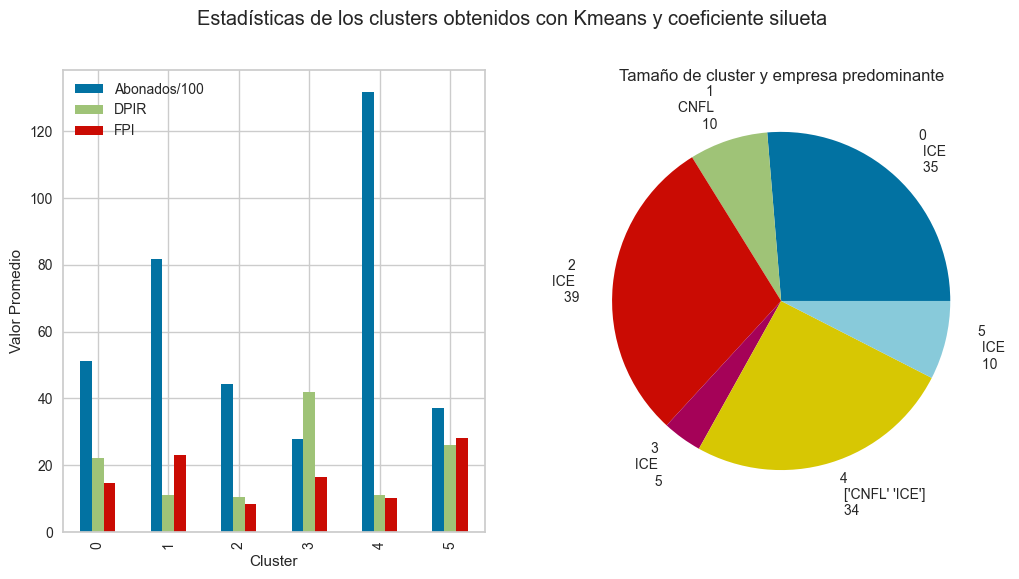

In [280]:
# generamos gráficos más comprensibles
data_kmeans_grouped1 = data_kmeans_sil.groupby("Cluster").agg({"Abonados":['mean'],
                                    "DPIR":['mean'],
                                    "FPI":['mean'],
                                  "Empresa":[pd.Series.mode]
                                    })

data_kmeans_grouped1['Abonados'] = data_kmeans_grouped1['Abonados']/100
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
data_kmeans_grouped1.plot(kind='bar',ax=ax[0], xlabel='Cluster', ylabel='Valor Promedio')
ax[0].legend(['Abonados/100', 'DPIR', 'FPI'])

empresas=[data_kmeans_grouped1.Empresa.values[i][0] for i in range(len(data_kmeans_grouped1.Empresa.values))]
data_kmeans_grouped2 = data_kmeans_sil.groupby("Cluster").agg({"Cluster":'count'})


formatter = [f"{i} \n {j} \n {l}" for i,j,l in zip(list(data_kmeans_grouped1.index),\
                                                   empresas,list(data_kmeans_grouped2.Cluster))]
ax[1].pie(data_kmeans_grouped2.Cluster, labels=formatter, labeldistance=1.2)
ax[1].set(title="Tamaño de cluster y empresa predominante")
fig.suptitle('Estadísticas de los clusters obtenidos con Kmeans y coeficiente silueta')
plt.show()

## Algoritmo 2: DBSCAN

Mediante prueba y error se concluyó que los clusters del algoritmo DBSCAN convergen en 2, y la cantidad mínima de puntos que rodean a un core point necesaria para conseguirlo fue 8

### Obtención de eps/epsilon

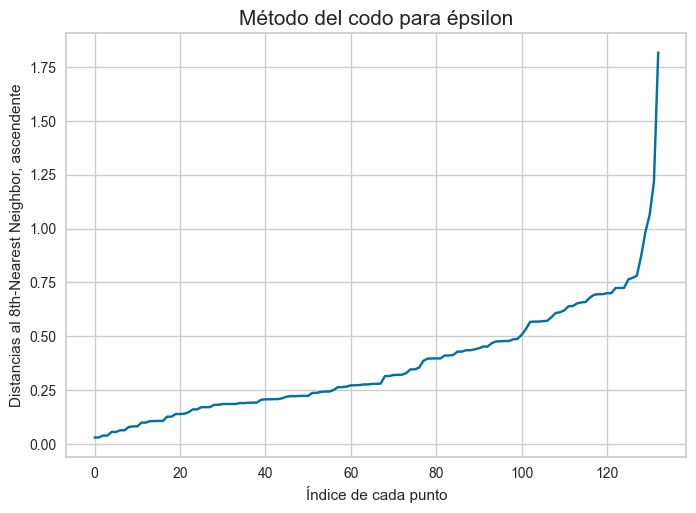

In [281]:
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(data)
distances, indices = neighbors_fit.kneighbors(data)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.title("Método del codo para épsilon", fontsize=15)
plt.ylabel("Distancias al 8th-Nearest Neighbor, ascendente")
plt.xlabel("Índice de cada punto")
plt.show()

In [282]:
dbscan = DBSCAN(eps=0.75, min_samples=4)
dbscan.fit(data)
data_DBSCAN = pd.DataFrame(datosA.copy()) #datos sin escalar
data_DBSCAN["Cluster"] = dbscan.labels_.astype(str).tolist()
data_DBSCAN["Cluster"].replace({'-1':'1'}, inplace=True)
fig = px.scatter_3d(data_DBSCAN, x="Abonados", y="DPIR", z="FPI", 
                    color="Cluster", title='Clústers hechos con DBSCAN')

fig.update_traces(
    textfont=dict(
        family="Arial",
        size=18,
        color="crimson" 
    ),
    marker=dict(
        size=5
    )
)
fig.show()

### Estadísticas

In [283]:
data_DBSCAN_grouped = data_DBSCAN.groupby("Cluster").agg({"Abonados":['mean'],
                                    "DPIR":['mean'],
                                    "FPI":['mean'],
                                  "Empresa":[pd.Series.mode],
                                    "Cluster":'count'})
print(data_DBSCAN_grouped)

            Abonados       DPIR        FPI Empresa Cluster
                mean       mean       mean    mode   count
Cluster                                                   
0        7115.096154  14.307596  11.635000     ICE     104
1        6638.517241  22.495172  19.702069     ICE      29


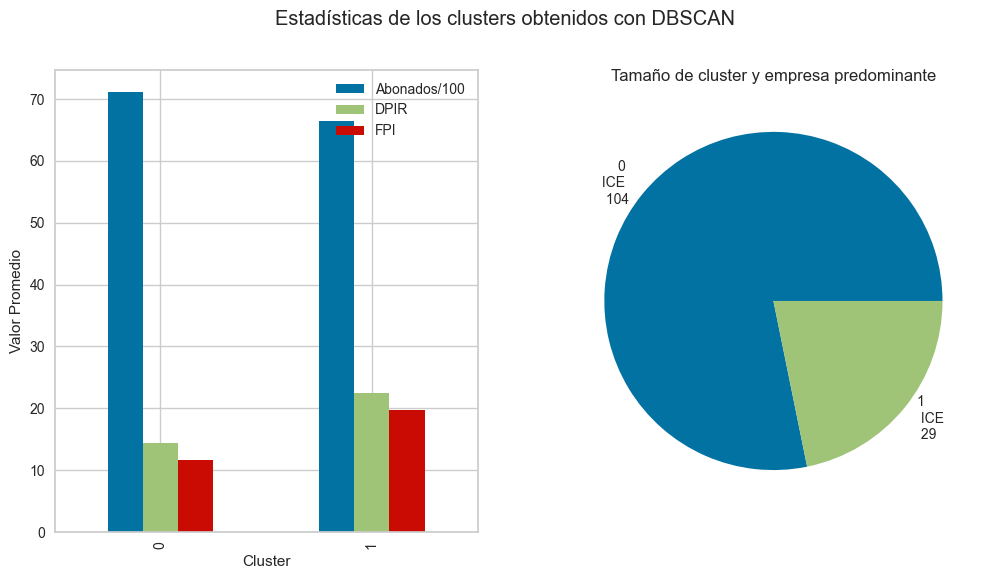

In [284]:
# generamos gráficos para entender mejor la data
data_DBSCAN_grouped1 = data_DBSCAN.groupby("Cluster").agg({"Abonados":['mean'],
                                    "DPIR":['mean'],
                                    "FPI":['mean'],
                                  "Empresa":[pd.Series.mode]
                                    })
data_DBSCAN_grouped1['Abonados'] = data_DBSCAN_grouped1['Abonados']/100

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
data_DBSCAN_grouped1.plot(kind='bar',ax=ax[0], xlabel='Cluster', ylabel='Valor Promedio')
ax[0].legend(['Abonados/100', 'DPIR', 'FPI'])


empresas=[data_DBSCAN_grouped1.Empresa.values[i][0] for i in range(len(data_DBSCAN_grouped1.Empresa.values))]
data_DBSCAN_grouped2 = data_DBSCAN.groupby("Cluster").agg({"Cluster":'count'})

formatter = [f"{i} \n {j} \n {l}" for i,j,l in zip(list(data_DBSCAN_grouped1.index),\
                                                   empresas,list(data_DBSCAN_grouped2.Cluster))]
ax[1].pie(data_DBSCAN_grouped2.Cluster, labels=formatter)
ax[1].set(title="Tamaño de cluster y empresa predominante")
fig.suptitle('Estadísticas de los clusters obtenidos con DBSCAN')
plt.show()

# Extra: Datos sin escalar

## K- means: Método del codo

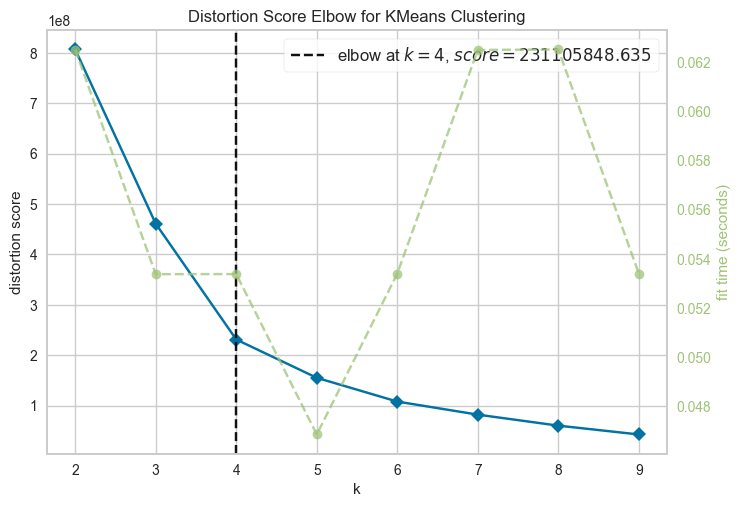

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [285]:
sin_escalar = datosA.select_dtypes(include=[int,float])
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,10))
 
visualizer.fit(sin_escalar)
visualizer.show()

In [286]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit(sin_escalar)
y_means = kmeans.predict(sin_escalar).astype(str)
y_means = y_means.reshape(133,1)
centers = kmeans.cluster_centers_ 
data_kmeans_elbow_sin_escalar =  datosA.copy()
data_kmeans_elbow_sin_escalar["Cluster"]= y_means

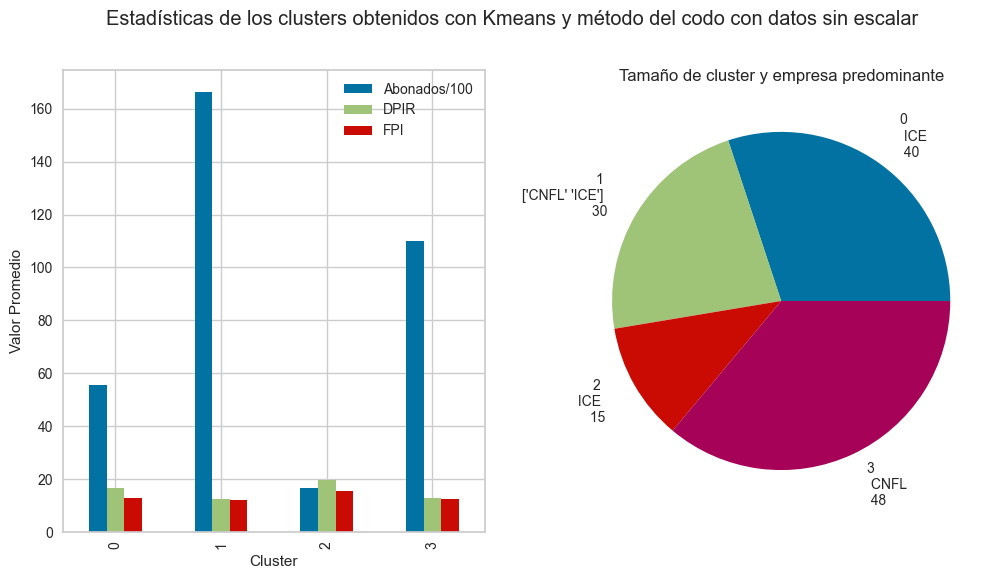

In [287]:
data_kmeans_grouped1 = data_kmeans_elbow_sin_escalar.groupby("Cluster").agg({"Abonados":['mean'],
                                    "DPIR":['mean'],
                                    "FPI":['mean'],
                                  "Empresa":[pd.Series.mode]
                                    })

data_kmeans_grouped1['Abonados'] = data_kmeans_grouped1['Abonados']/100
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
data_kmeans_grouped1.plot(kind='bar',ax=ax[0], xlabel='Cluster', ylabel='Valor Promedio')
ax[0].legend(['Abonados/100', 'DPIR', 'FPI'])

empresas=[data_kmeans_grouped1.Empresa.values[i][0] for i in range(len(data_kmeans_grouped1.Empresa.values))]
data_kmeans_grouped2 = data_kmeans_elbow.groupby("Cluster").agg({"Cluster":'count'})


formatter = [f"{i} \n {j} \n {l}" for i,j,l in zip(list(data_kmeans_grouped1.index),\
                                                   empresas,list(data_kmeans_grouped2.Cluster))]
ax[1].pie(data_kmeans_grouped2.Cluster, labels=formatter, labeldistance=1.2)
ax[1].set(title="Tamaño de cluster y empresa predominante")
fig.suptitle('Estadísticas de los clusters obtenidos con Kmeans y método del codo con datos sin escalar')
plt.show()

In [288]:
fig = px.scatter_3d(data_kmeans_elbow_sin_escalar, x="Abonados", y="DPIR", z="FPI", color="Cluster", 
                    title='Clústers sin escalar hechos con K-means y método del codo')
fig.add_trace(go.Scatter3d(
    x=centers[:, 0],
    y=centers[:, 1],
    z=centers[:, 2],
    mode='markers',
    marker=dict(size=20, color='yellow',symbol='diamond'),
    name='Centroids'
))

fig.update_traces(
    textfont=dict(
        family="Arial",
        size=15,
        color="crimson"  
    ),
    marker=dict(
        size=5,
    )
)
fig.show()